# ISC analysis with `nosmooth.mat` files


We can do an ISC either by treating each row (**block**) as a variable, or by treating each column (**voxel**) as a variable.

### Correlating the voxel patterns of the respective blocks

- In the study from (Chen et al., 2016) they divided the BOLD data obtained from watching and recalling a Sherlock movie up in 50 scenes. This resulted in one vector voxel values for each recalled scene. As such, they compute the correlation between every matching pair of recalled scenes.

> **Here, we treat the blocks/levels/boxcars the (*rows*), as a variable**. That is, we compute the correlation between every matching pair of blocks/levels/boxcars


## General process

For all the data, we perform the following steps:

### 1. Load data in notebook
(we are dealing with .mat files) (Remark. note that we have 3 different types of data. glm1, glm24, glm25)

The repetition time (TR) is different for each glm. So for example, TR of glm1 is one block, so 3x60s = 180s.

The blocks (glm 1); TR = 180 s
The levels (glm 25); TR = 60 s
The 10 seconds boxcars (glm 24); TR = 10 s

### 2. Preprocess and reorder the rows in B, the average activity captured by the boxcar regressor for each block (the $\beta_i's$ ).

### 3. Do ISC analysis

In [2]:
import h5py
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 

# import own functions
import utils
reload(utils)

%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 30 seconds


# 1. ISC with blocks

for blocks we take the `glm1` files

```Python
filename = 'beta_series_glm1_subj*_nosmooth.mat'
```



## 1.1 Load in data


In [13]:
num_subjects = 8

B_data_blocks = []
mask_data_blocks = []
Vmask_data_blocks = []
names_data_blocks = []

for i in range(num_subjects):
    idx = i+1
    
    # change filename to subject #
    data_dir = '/Users/Daphne/Desktop/beta_series_nosmooth/'
    filename = 'beta_series_glm1_subjk_nosmooth.mat'
    filename = filename.replace('k', str(idx))
    
    subject = h5py.File(data_dir+filename,'r') 
    #print(list(subject.keys()))
    print(f'Get data for subject {idx}')
    # load and save data for respective subject
    B = subject['B'].value
    mask = subject['mask'].value
    Vmask = subject['Vmask']
    
    # === decode level names ===
    names = decode_variable(data_dir+filename, 'names')
    
    # append to lists
    B_data_blocks.append(B)
    mask_data_blocks.append(mask)
    Vmask_data_blocks.append(Vmask)
    names_data_blocks.append(names)

Get data for subject 1
Get data for subject 2
Get data for subject 3
Get data for subject 4
Get data for subject 5
Get data for subject 6
Get data for subject 7
Get data for subject 8


In [14]:
print(names_data_blocks[0][0:10])

['Sn(1) vgfmri3_chase*bf(1)' 'Sn(1) vgfmri3_lemmings*bf(1)'
 'Sn(1) vgfmri3_bait*bf(1)' 'Sn(2) vgfmri3_plaqueAttack*bf(1)'
 'Sn(2) vgfmri3_helper*bf(1)' 'Sn(2) vgfmri3_zelda*bf(1)'
 'Sn(3) vgfmri3_lemmings*bf(1)' 'Sn(3) vgfmri3_plaqueAttack*bf(1)'
 'Sn(3) vgfmri3_zelda*bf(1)' 'Sn(4) vgfmri3_chase*bf(1)']


In [17]:
B_data_blocks[0].shape # voxels x blocks

(179595, 18)

## 1.2 Preprocessing

In [22]:
ISC_arr_blocks = []
ordered_dfs_blocks = []

for s in range(num_subjects):
    
    print(f'Preprocess fMRI blocks data for subject {s+1}')
    # get the betas and game order from this
    B_s = B_data_blocks[s].T # transpose to get [blocks, voxels]
    names_s = names_data_blocks[s]
    
    dfOrdered, B_ordered = get_in_shape_blocks(B_s, names_s)
    
    ISC_arr_blocks.append(B_ordered)
    ordered_dfs_blocks.append(dfOrdered)
    
ISC_arr_blocks = np.array(ISC_arr_blocks)

Preprocess fMRI blocks data for subject 1
Preprocess fMRI blocks data for subject 2
Preprocess fMRI blocks data for subject 3
Preprocess fMRI blocks data for subject 4
Preprocess fMRI blocks data for subject 5
Preprocess fMRI blocks data for subject 6
Preprocess fMRI blocks data for subject 7
Preprocess fMRI blocks data for subject 8


In [23]:
# get datat in the right shape to perform ISC with brainiak
# swap those axes!
blocks_ISC = np.swapaxes(ISC_arr_blocks, 0, 1) # need to get [TRs, voxels, subjects]
blocks_ISC = np.swapaxes(blocks_ISC, 1, 2)

blocks_ISC.shape

(18, 179595, 8)

## 1.3 ISC

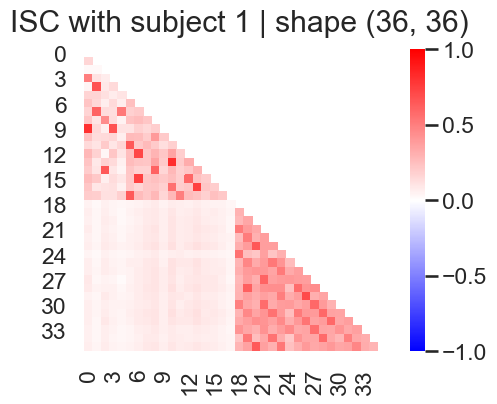

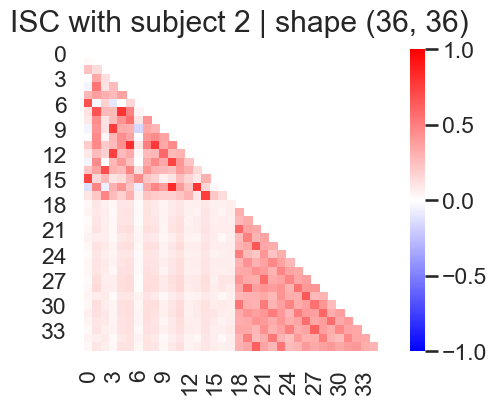

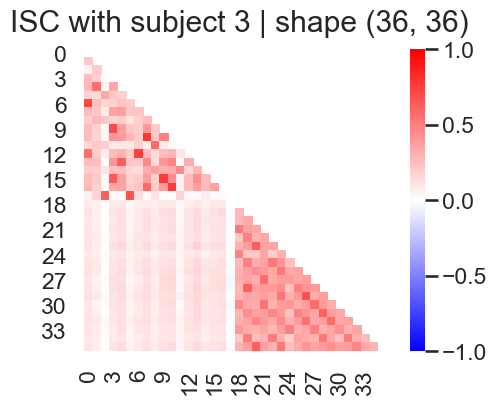

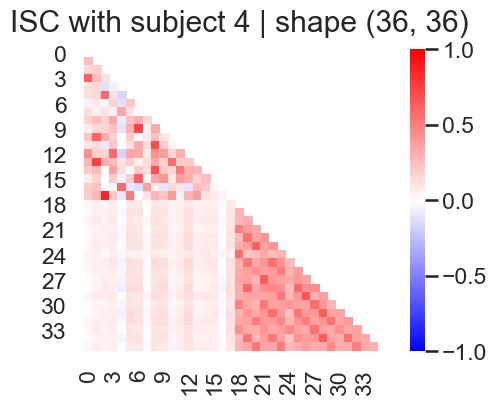

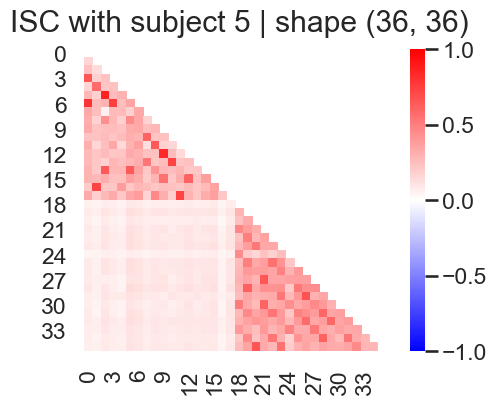

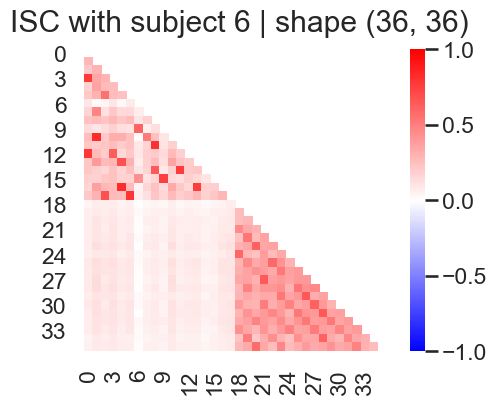

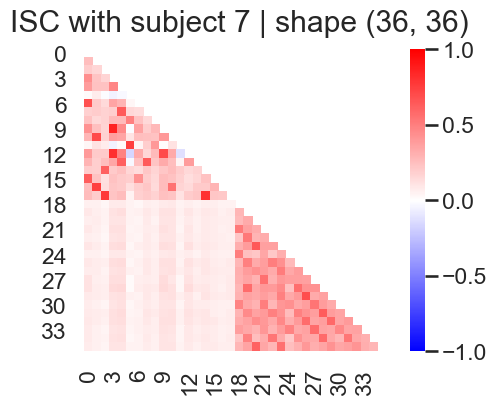

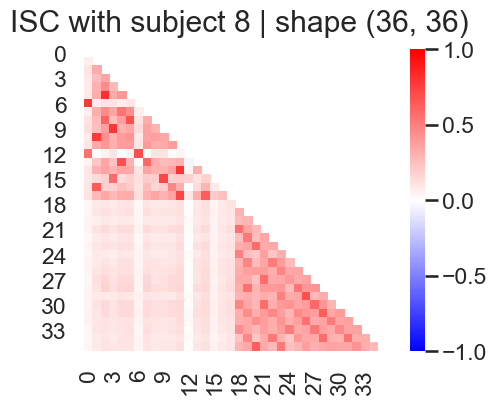

In [24]:
for i in range(num_subjects):
    
    M_sub = blocks_ISC[:,:,i] # take the subject matrix 
    M_rest = np.delete(blocks_ISC, i, axis=2) # remove this subjects' data from whole dataset
    
    #print(M_rest.shape)
    # compute average of other matrices
    M_rest_mean = np.mean(M_rest, axis=2)
    
    # now compute correlation between mean matrix & subj matrix
    C_blockpatterns = np.corrcoef(M_sub, M_rest_mean, rowvar=True) # treat rows as variables
    
#     f, ax = plt.subplots(1,1, dpi=100)
#     f.suptitle(f'ISC with subject {i+1}')
#     sns.heatmap(C_blockpatterns, ax=ax, linewidth=0.3, cmap='bwr', vmin=-1, vmax=1);

    mask = np.zeros_like(C_blockpatterns)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(1,1, dpi=100)
        f.suptitle(f'ISC with subject {i+1} | shape {C_blockpatterns.shape}')
        ax = sns.heatmap(C_blockpatterns, mask=mask, ax=ax, square=True, cmap='bwr', vmin=-1, vmax=1);  

## 2. ISC with levels

for levels we take the glm25 files

```python
filename = 'beta_series_glm25_subj*_nosmooth.mat'
```

## 2.1 Load in nosmooth levels data

In [3]:
num_subjects = 8

B_data_levels = []
mask_data_levels = []
Vmask_data_levels = []
names_data_levels = []

for i in range(num_subjects):
    idx = i+1
    
    # change filename to subject #
    data_dir = '/Users/Daphne/Desktop/beta_series_nosmooth/'
    filename = 'beta_series_glm25_subjk_nosmooth.mat'
    filename = filename.replace('k', str(idx))
    
    subject = h5py.File(data_dir+filename,'r') 
    #print(list(subject.keys()))
    print(f'Get data for subject {idx}')
    # load and save data for respective subject
    B = subject['B'].value
    mask = subject['mask'].value
    Vmask = subject['Vmask']
    
    # === decode level names ===
    names = decode_variable(data_dir+filename, 'names')
    
    # append to lists
    B_data_levels.append(B)
    mask_data_levels.append(mask)
    Vmask_data_levels.append(Vmask)
    names_data_levels.append(names)

Get data for subject 1
Get data for subject 2
Get data for subject 3
Get data for subject 4
Get data for subject 5
Get data for subject 6
Get data for subject 7
Get data for subject 8


In [12]:
# save a nonsmooth mask
mask_mat_SM = mask_data_levels[0]

np.save('mask_mat_SM', mask_mat_SM)

## 2.2 Preprocess

1. Clean the level name strings

2. Reorder the BOLD data

    - split the list of strings `names` into 3 parts: `game, instance, session`.
    - sort the data first by game, then session, then instance (default = quicksort)
    - insert a levels column to the ordered dataframes

In [4]:
ISC_arr_levels = []
ordered_dfs_levels = []
clean_names_arr = [] 

for s in range(num_subjects):
    
    print(f'Preprocess fMRI data for subject {s+1}')
    # get the betas and game order from this
    B_s = B_data_levels[s].T # transpose to get [blocks, voxels]
    names_s = names_data_levels[s]
    
    level_names, dfOrdered, B_ordered = get_in_shape_levels(B_s, names_s)
    
    ISC_arr_levels.append(B_ordered)
    ordered_dfs_levels.append(dfOrdered)
    clean_names_arr.append(level_names)
    
ISC_arr_levels = np.array(ISC_arr_levels)

Preprocess fMRI data for subject 1
Preprocess fMRI data for subject 2
Preprocess fMRI data for subject 3
Preprocess fMRI data for subject 4
Preprocess fMRI data for subject 5
Preprocess fMRI data for subject 6
Preprocess fMRI data for subject 7
Preprocess fMRI data for subject 8


In [5]:
ISC_arr_levels.shape

(8, 54, 179595)

In [6]:
# get datat in the right shape to perform ISC with brainiak
# swap those axes!
levels_ISC = np.swapaxes(ISC_arr_levels, 0, 1) # need to get [TRs, voxels, subjects]
levels_ISC = np.swapaxes(levels_ISC, 1, 2)

levels_ISC.shape

(54, 179595, 8)

In [7]:
np.save('levels_betas_NS.npy', levels_ISC)

## 2.3 ISC

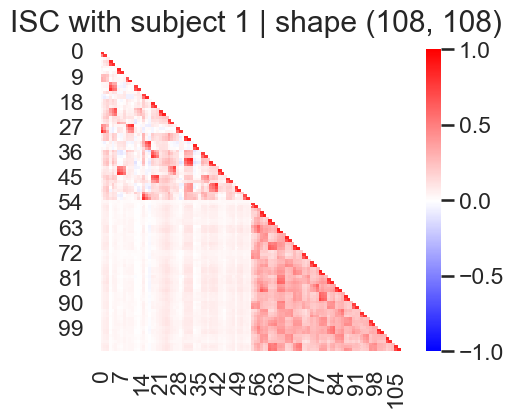

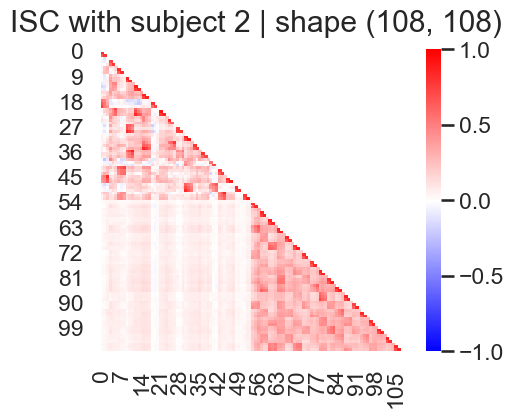

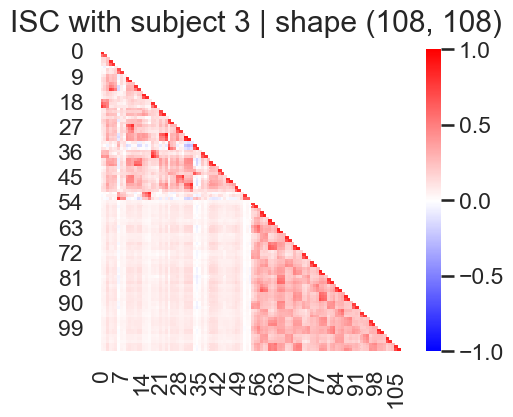

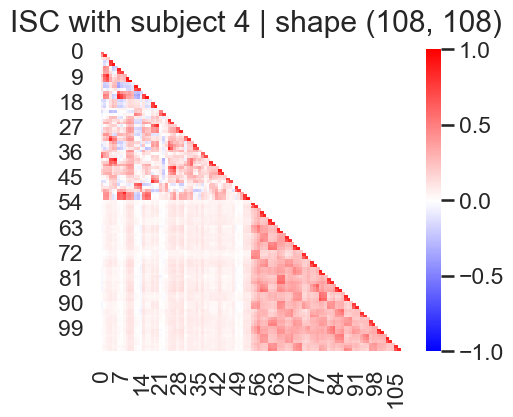

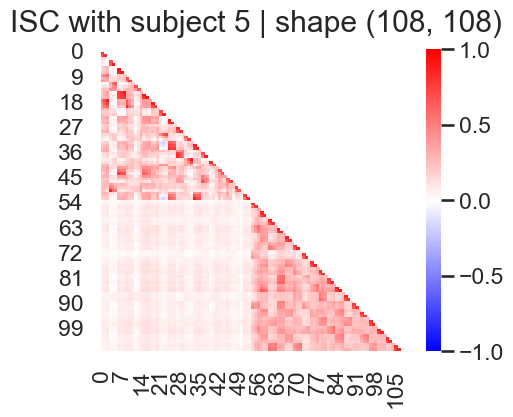

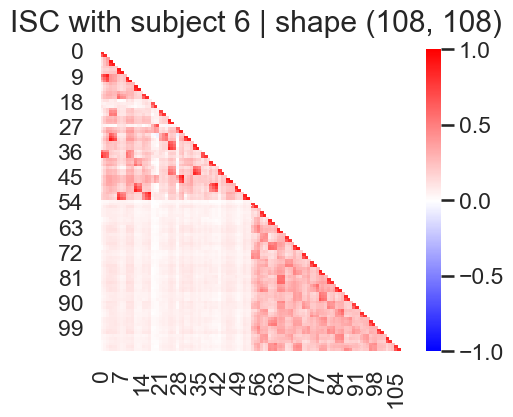

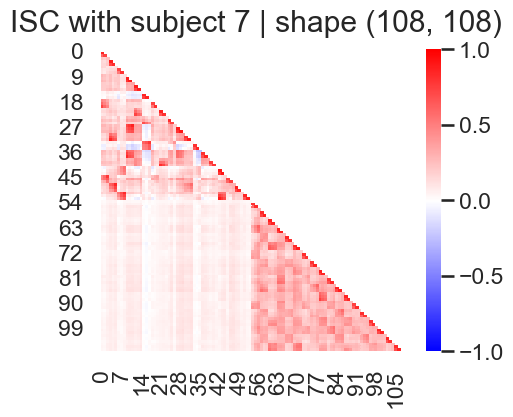

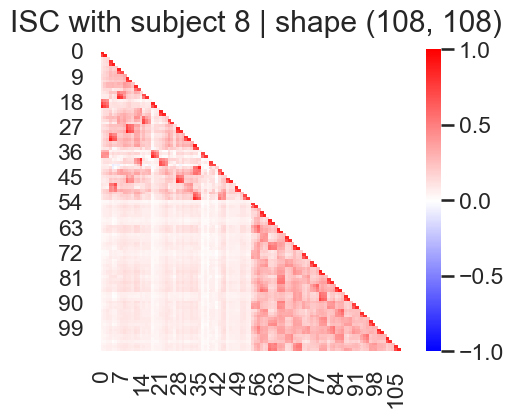

In [30]:
for i in range(num_subjects):
    
    M_sub = levels_ISC[:,:,i] # take the subject matrix 
    M_rest = np.delete(levels_ISC, i, axis=2) # remove this subjects' data from whole dataset
    
    #print(M_rest.shape)
    # compute average of other matrices
    M_rest_mean = np.mean(M_rest, axis=2)
    
    # now compute correlation between mean matrix & subj matrix
    C_blockpatterns = np.corrcoef(M_sub, M_rest_mean, rowvar=True) # treat rows as variables
    
#     f, ax = plt.subplots(1,1, dpi=100)
#     f.suptitle(f'ISC with subject {i+1}')
#     sns.heatmap(C_blockpatterns, ax=ax, linewidth=0.3, cmap='bwr', vmin=-1, vmax=1);

    mask = np.zeros_like(C_blockpatterns)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(1,1, dpi=100)
        f.suptitle(f'ISC with subject {i+1} | shape {C_blockpatterns.shape}')
        ax = sns.heatmap(C_blockpatterns, mask=mask, ax=ax, square=True, cmap='bwr', vmin=-1, vmax=1);  